# Model: Expected of probabiliteies from SVC RBF

In [1]:
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
from tqdm import tqdm

plt.ion()

In [2]:
import sys
sys.path.append('../../data')
from corpus import load_corpus
data = load_corpus('weebit')

feature_names = data['feature_names']
FEATURES_NAMES = data['FEATURES_NAMES']

X_train = data['X_train']
y_train = data['y_train']
y_train_onehot = data['y_train_onehot']
X_test = data['X_test']
y_test = data['y_test']
y_test_onehot = data['y_test_onehot']

Using TensorFlow backend.


In [3]:
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV

In [4]:
param_scale = 10.**np.arange(-1, 1)
param_grid = {'C': param_scale}

In [5]:
%%time

clf = GridSearchCV(SVC(kernel='rbf'), param_grid=param_grid)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test), clf.best_params_['C'])

0.7087912087912088 1.0
CPU times: user 5.24 s, sys: 4 ms, total: 5.24 s
Wall time: 5.24 s


In [6]:
%%time

clf = GridSearchCV(LinearSVC(), param_grid=param_grid)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test), clf.best_params_['C'])

0.6771978021978022 1.0
CPU times: user 7.96 s, sys: 5.67 s, total: 13.6 s
Wall time: 6.52 s


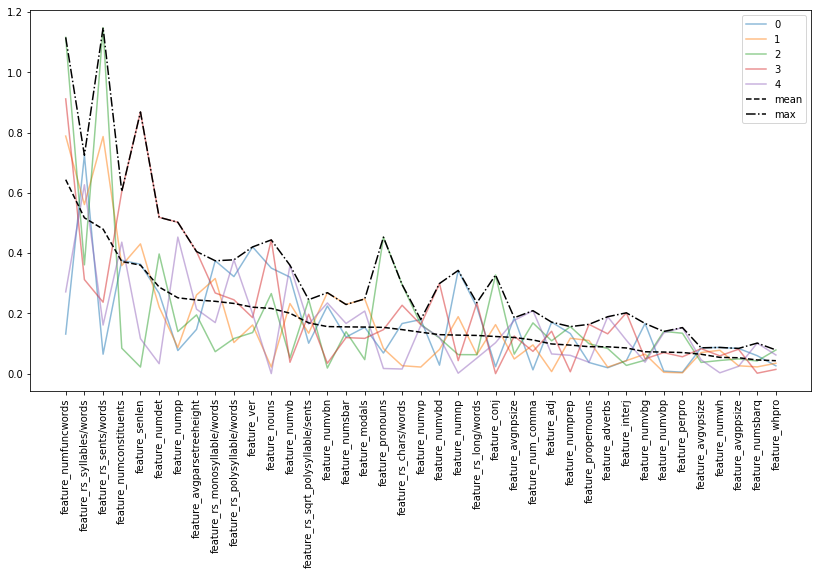

In [7]:
f, ax = plt.subplots(1, figsize=(14, 7))

linear_svm = LinearSVC(C=1).fit(X_train, y_train)

coef_mean = np.abs(linear_svm.coef_).mean(axis=0)
coef_max = np.abs(linear_svm.coef_).max(axis=0)
feature_order_by_mean = np.argsort(np.abs(coef_mean))[::-1]
feature_names_order_by_mean = np.take(feature_names, feature_order_by_mean)

for i, coef in enumerate(linear_svm.coef_):
    plt.plot(np.abs(coef)[feature_order_by_mean], '-', label=i, alpha=0.5)

plt.plot(coef_mean[feature_order_by_mean], '--', label='mean', color='black')
plt.plot(coef_max[feature_order_by_mean], '-.', label='max', color='black')

plt.xticks(range(len(linear_svm.coef_[0])), feature_names_order_by_mean, rotation=90)
plt.legend()

In [8]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
random_feature_order = np.random.permutation(feature_order_by_mean)


def threshold_avg_pred_socre(estimator, X, y, *args):
    #y_pred = estimator.predict(X).flatten()
    y_pred_probs = estimator.predict_proba(X)
    y_pred_avg = (y_pred_probs * np.arange(5)).sum(axis=1)
    y_pred_avg_classes = y_pred_avg.round().clip(0, 4).astype(int)
    # y_pred_classes = np.clip(y_pred.round().astype(int), 0, 4)
    return np.sum(np.abs(y - y_pred_avg_classes) <= 1) / len(y)

def accuracy_avg_pred_socre(estimator, X, y, *args):
    #y_pred = estimator.predict(X).flatten()
    y_pred_probs = estimator.predict_proba(X)
    y_pred_avg = (y_pred_probs * np.arange(5)).sum(axis=1)
    y_pred_avg_classes = y_pred_avg.round().clip(0, 4).astype(int)
    # y_pred_classes = np.clip(y_pred.round().astype(int), 0, 4)
    return accuracy_score(y, y_pred_avg_classes)

scoring = {'threshold': threshold_avg_pred_socre,
          'accuracy': accuracy_avg_pred_socre}

def scores2stats(scores):
    return {'mean': scores.mean(),
            'ci': scores.std() * 2
           }

def get_scores_svm_rbf(sub_features, cv=10):
    kernel_svm = SVC(C=1)
    X_sub_features = X_train.loc[:, sub_features]
    
    scores = cross_validate(SVC(C=1, probability=True), X_sub_features, y_train,
                            cv=cv,
                            scoring=scoring,
                            return_train_score=False)
    return {'accuracy': scores2stats(scores['test_accuracy']),
            'threshold': scores2stats(scores['test_threshold']),
           }

In [9]:
scores_orderd = [get_scores_svm_rbf(np.take(feature_names, feature_order_by_mean)[:i], cv=3) for i in tqdm(range(1, 40))]
scores_random = [get_scores_svm_rbf(np.take(feature_names, random_feature_order)[:i], cv=3) for i in tqdm(range(1, 40))]

100%|██████████| 39/39 [02:43<00:00,  5.25s/it]


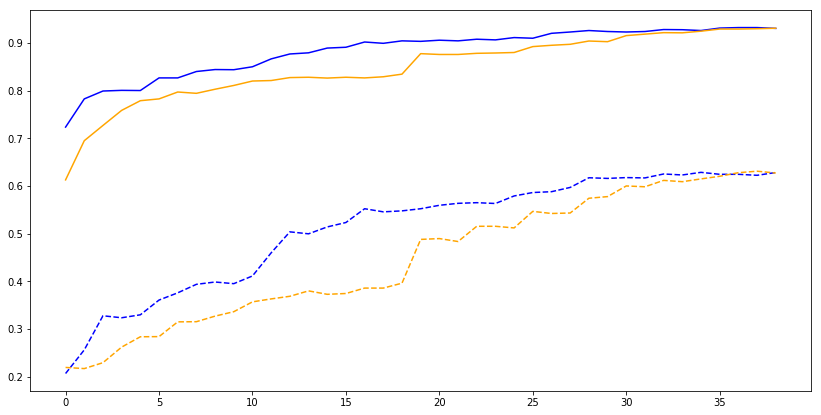

In [10]:
def plot_scores_by_n_features(scores_by_n_features, color, ax):
    accuracy_mean = [scores['accuracy']['mean'] for scores in scores_by_n_features]
    accuracy_ci = [scores['accuracy']['ci'] for scores in scores_by_n_features]
    threshold_mean = [scores['threshold']['mean'] for scores in scores_by_n_features]
    threshold_ci = [scores['threshold']['ci'] for scores in scores_by_n_features]
    
    plt.plot(threshold_mean, '-', c=color)
    plt.plot(accuracy_mean, '--', c=color)
    
    
f, ax = plt.subplots(1, figsize=(14, 7))

plot_scores_by_n_features(scores_orderd, 'blue', ax)
plot_scores_by_n_features(scores_random, 'orange', ax)

In [11]:
features2group = {v: k for k in FEATURES_NAMES for v in FEATURES_NAMES[k]}

group2value = {'POS_DENSITY': 1,
              'READABILITY_SCORES': 2,
              'SYNTACTIC_COMPLEXITY': 3}

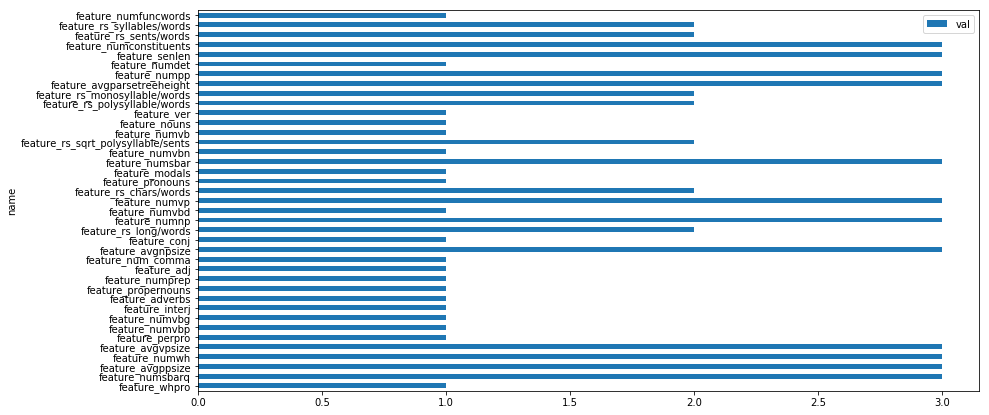

In [12]:
f, ax = plt.subplots(figsize=(14, 7))
(pd.DataFrame([{'name': name, 'val': group2value[features2group[name]]} for name in feature_names_order_by_mean])
 .set_index('name'))[::-1].plot(kind='barh', ax=ax)

In [13]:
from itertools import chain, combinations

FEATURE_SUBSETS = chain.from_iterable(combinations(FEATURES_NAMES.keys(), n) for n in range(1, len(FEATURES_NAMES)+1))

features_groups_scores = {' + '.join(features_subsets): get_scores_svm_rbf(
    sum([FEATURES_NAMES[features_subset]
         for features_subset in features_subsets], []))
     for features_subsets in tqdm(FEATURE_SUBSETS)}

7it [02:38, 24.33s/it]


In [14]:
name = 'threshold'
groups_score_df = pd.DataFrame({k: v[name] for k,v in features_groups_scores.items()})
groups_score_df = groups_score_df.transpose()

In [38]:
def make_groups_score_df(features_groups_scores, name): 
    groups_score_df = pd.DataFrame({k: v[name] for k,v in features_groups_scores.items()})
    groups_score_df = groups_score_df.transpose()
    groups_score_df = groups_score_df.sort_values('mean', ascending=False)
    groups_score_df['n_groups'] = groups_score_df.index.map(lambda s: s.count('+'))
    return groups_score_df


from matplotlib.patches import Rectangle

plus2colors = {0: 'red',
               1: 'blue',
               2: 'green',
               3: 'purple'}


def plot_groups_score_df(groups_score_df, ax):

    colors = groups_score_df['n_groups'].map(plus2colors)

    plt.errorbar(
        groups_score_df['mean'],
        groups_score_df.index,
        xerr=groups_score_df['ci'],
        fmt='o',
        color='black',
        ecolor=colors)

    plt.title('Features Groups - SVM RBF (C=1) - Threshold & Accuracy - Seperated with Confidence Interval')
    plt.ylabel('Features Groups')
    

In [39]:
threshold_groups_df = make_groups_score_df(features_groups_scores, 'threshold')
accuracy_groups_df = make_groups_score_df(features_groups_scores, 'accuracy')

threshold_groups_df = threshold_groups_df.sort_values('mean')
accuracy_groups_df = accuracy_groups_df.reindex(threshold_groups_df.index)
assert (threshold_groups_df.index == accuracy_groups_df.index).all()

In [40]:
accuracy_groups_df.sort_values('mean', ascending=False)

,ci,mean,n_groups
POS_DENSITY + READABILITY_SCORES + SYNTACTIC_COMPLEXITY,0.048936,0.637499,2
POS_DENSITY + READABILITY_SCORES,0.035794,0.617575,1
POS_DENSITY + SYNTACTIC_COMPLEXITY,0.054120,0.614111,1
POS_DENSITY,0.056254,0.586241,0
READABILITY_SCORES + SYNTACTIC_COMPLEXITY,0.044556,0.437716,1
SYNTACTIC_COMPLEXITY,0.052268,0.392313,0
READABILITY_SCORES,0.039670,0.319796,0


In [41]:
threshold_groups_df.sort_values('mean', ascending=False)

,ci,mean,n_groups
POS_DENSITY + READABILITY_SCORES + SYNTACTIC_COMPLEXITY,0.023034,0.935708,2
POS_DENSITY + READABILITY_SCORES,0.017947,0.927431,1
POS_DENSITY + SYNTACTIC_COMPLEXITY,0.025125,0.923320,1
POS_DENSITY,0.031244,0.907821,0
READABILITY_SCORES + SYNTACTIC_COMPLEXITY,0.028460,0.872425,1
SYNTACTIC_COMPLEXITY,0.035553,0.834578,0
READABILITY_SCORES,0.045413,0.798847,0


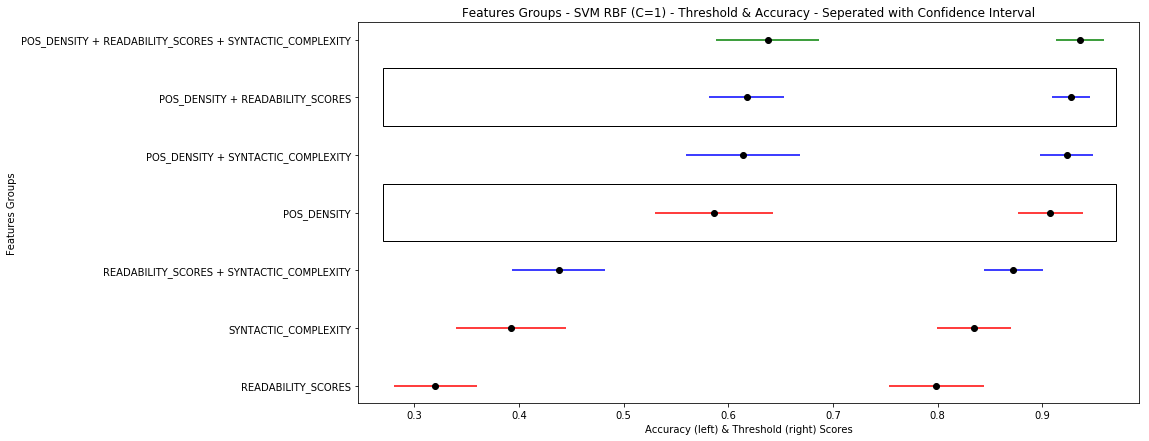

In [49]:
f, ax = plt.subplots(1, figsize=(14, 7))
plot_groups_score_df(threshold_groups_df, ax)
plot_groups_score_df(accuracy_groups_df, ax)

plt.xlabel('Accuracy (left) & Threshold (right) Scores')

el_pos_rs = Rectangle((0.27, 2.5), 0.7, 1, fill=False)
ax.add_artist(el_pos_rs)

el_pos = Rectangle((0.27, 4.5), 0.7, 1, fill=False)
ax.add_artist(el_pos)


plt.savefig('features-groups-svm-rbf-threshold-accuracy-sperated-ci.png', dpi=300)


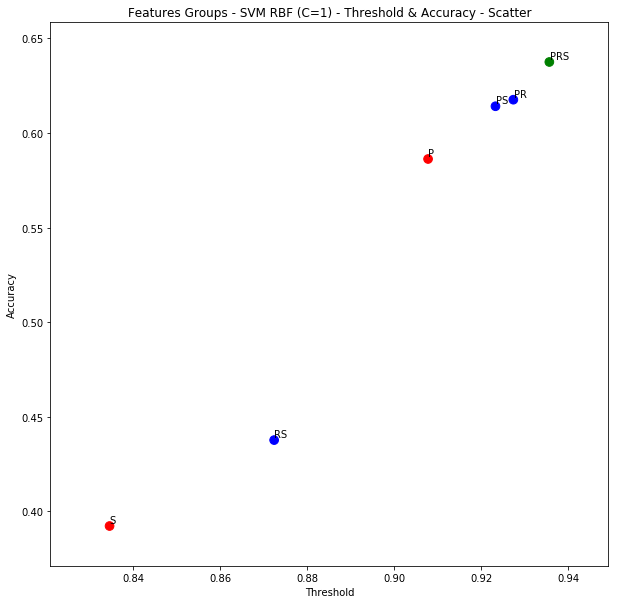

In [45]:
from adjustText import adjust_text


f, ax = plt.subplots(1, figsize=(10, 10))
colors = threshold_groups_df['n_groups'][1:].map(plus2colors)
plt.scatter(threshold_groups_df['mean'][1:], accuracy_groups_df['mean'][1:], c=colors, s=75)


plt.title('Features Groups - SVM RBF (C=1) - Threshold & Accuracy - Scatter')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')

texts = [ax.text(threshold, accuracy, ''.join([group[0] for group in name.split(' + ')]))
             for (name, (threshold, accuracy)) in zip(threshold_groups_df.index[1:],
                             zip(threshold_groups_df['mean'][1:], accuracy_groups_df['mean'][1:]))]
adjust_text(texts)

plt.savefig('features-groups-svm-rbf-threshold-accuracy-scatter.png', dpi=300)

